In [10]:

import sys
!{sys.executable} -m pip install --quiet yfinance pyarrow --upgrade

import os
from datetime import datetime
import pandas as pd
import yfinance as yf

symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
start_date = "2018-01-01"
end_date = "2025-10-31"

out_dir = "data/processed"
os.makedirs(out_dir, exist_ok=True)
out_parquet = os.path.join(out_dir, "prices.parquet")

all_frames = []
for s in symbols:
    print(f"Downloading {s} ...")
    t = yf.Ticker(s)

    df = t.history(start=start_date, end=end_date, auto_adjust=False, actions=False)
    if df.empty:
        raise RuntimeError(f"No data returned for {s}.")
    df = df.reset_index()
    df["symbol"] = s

    if "Adj Close" in df.columns:
        df = df.rename(columns={"Adj Close": "adj_close", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
    else:
        df = df.rename(columns={"Adj Close": "adj_close", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

    keep_cols = ["Date", "symbol", "open", "high", "low", "close", "volume"]
    if "adj_close" in df.columns:
        keep_cols.insert(6, "adj_close")
    df = df[[c for c in keep_cols if c in df.columns]]
    df = df.rename(columns={"Date": "date"})

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["symbol", "date"]).reset_index(drop=True)
    all_frames.append(df)
prices = pd.concat(all_frames, ignore_index=True)

counts = prices.groupby("symbol").size().to_dict()
print("Rows per symbol:", counts)
print("Total rows:", len(prices))

prices.to_parquet(out_parquet, index=False, engine="pyarrow")
print(f"Saved raw prices to {out_parquet}")

display(prices.head(8))
display(prices.tail(8))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 23.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
Rows per symbol: {'AAPL': 1969, 'AMZN': 1969, 'GOOGL': 1969, 'MSFT': 1969, 'TSLA': 1969}
Total rows: 9845
Saved raw prices to data/processed/prices.parquet


,date,symbol,open,high,low,close,adj_close,volume
0,2018-01-02 00:00:00-05:00,AAPL,42.540001,43.075001,42.314999,43.064999,40.380993,102223600
1,2018-01-03 00:00:00-05:00,AAPL,43.132500,43.637501,42.990002,43.057499,40.373962,118071600
2,2018-01-04 00:00:00-05:00,AAPL,43.134998,43.367500,43.020000,43.257500,40.561497,89738400
3,2018-01-05 00:00:00-05:00,AAPL,43.360001,43.842499,43.262501,43.750000,41.023312,94640000
4,2018-01-08 00:00:00-05:00,AAPL,43.587502,43.902500,43.482498,43.587502,40.870930,82271200
5,2018-01-09 00:00:00-05:00,AAPL,43.637501,43.764999,43.352501,43.582500,40.866234,86336000
6,2018-01-10 00:00:00-05:00,AAPL,43.290001,43.575001,43.250000,43.572498,40.856865,95839600
7,2018-01-11 00:00:00-05:00,AAPL,43.647499,43.872501,43.622501,43.820000,41.088940,74670800


,date,symbol,open,high,low,close,adj_close,volume
9837,2025-10-21 00:00:00-04:00,TSLA,445.760010,449.299988,442.049988,442.600006,442.600006,54412200
9838,2025-10-22 00:00:00-04:00,TSLA,443.450012,445.540009,429.000000,438.970001,438.970001,84023500
9839,2025-10-23 00:00:00-04:00,TSLA,420.000000,449.399994,413.899994,448.980011,448.980011,126709800
9840,2025-10-24 00:00:00-04:00,TSLA,446.829987,451.679993,430.170013,433.720001,433.720001,94727800
9841,2025-10-27 00:00:00-04:00,TSLA,439.980011,460.160004,438.690002,452.420013,452.420013,105867500
9842,2025-10-28 00:00:00-04:00,TSLA,454.779999,467.000000,451.600006,460.549988,460.549988,80185700
9843,2025-10-29 00:00:00-04:00,TSLA,462.500000,465.700012,452.649994,461.510010,461.510010,67983500
9844,2025-10-30 00:00:00-04:00,TSLA,451.049988,455.059998,439.609985,440.100006,440.100006,72128500


In [18]:
import os
import pandas as pd
import numpy as np

in_parquet = "data/processed/prices.parquet"
out_parquet = "data/processed/prices_clean.parquet"

if not os.path.exists(in_parquet):
    raise FileNotFoundError(f"Expected raw data at {in_parquet} but file not found.")

prices = pd.read_parquet(in_parquet)

if isinstance(prices["date"].dtype, pd.DatetimeTZDtype):
    prices["date"] = prices["date"].dt.tz_convert(None)
prices["date"] = pd.to_datetime(prices["date"])

prices.columns = [c.lower() for c in prices.columns]

price_col = "adj_close" if "adj_close" in prices.columns else "close"
if price_col not in prices.columns:
    raise RuntimeError("No valid price column found (expected 'adj_close' or 'close').")

prices = prices.sort_values(["symbol", "date"]).reset_index(drop=True)

def fe_group(df):
    df = df.copy().sort_values("date")
    df["daily_return"] = df[price_col].pct_change()
    df["ma_20"] = df[price_col].rolling(window=20, min_periods=20).mean()
    df["ma_50"] = df[price_col].rolling(window=50, min_periods=50).mean()
    df["volatility_20"] = df["daily_return"].rolling(window=20, min_periods=20).std()
    df["daily_return_filled_for_cum"] = df["daily_return"].fillna(0.0)
    df["cumulative_return"] = (1 + df["daily_return_filled_for_cum"]).cumprod()
    df.drop(columns=["daily_return_filled_for_cum"], inplace=True)
    return df

frames = []
for sym, grp in prices.groupby("symbol"):
    frames.append(fe_group(grp))
prices_fe = pd.concat(frames, ignore_index=True)

prices_fe = prices_fe.dropna(subset=[price_col])
required_features = ["daily_return", "ma_20", "ma_50", "volatility_20", "cumulative_return"]
prices_clean = prices_fe.dropna(subset=required_features).reset_index(drop=True)

print("Rows before cleaning:", len(prices))
print("Rows after feature engineering (before dropping NA features):", len(prices_fe))
print("Rows after dropping NA required features:", len(prices_clean))
print("Rows per symbol (clean):")
print(prices_clean.groupby("symbol").size().to_dict())

def check_date_gaps(df):
    df = df.sort_values("date")
    full_range = pd.date_range(df["date"].min(), df["date"].max(), freq="B")
    existing_dates = pd.to_datetime(df["date"].dt.floor("D").unique())
    missing = sorted(set(full_range.date) - set(existing_dates.date))
    return missing

missing_dates_summary = {}
for symbol, group in prices_clean.groupby("symbol"):
    missing = check_date_gaps(group)
    missing_dates_summary[symbol] = len(missing)

print("\nMissing business days per symbol:")
for symbol, count in missing_dates_summary.items():
    print(f"{symbol}: {count} missing days")

dupes = prices_clean.duplicated(subset=["symbol", "date"]).sum()
print(f"\nDuplicate date entries across all symbols: {dupes}")

num_cols = ["open", "high", "low", "close", "adj_close", "volume",
             "daily_return", "ma_20", "ma_50", "volatility_20", "cumulative_return"]
missing_counts = prices_clean[num_cols].isna().sum()
print("\nMissing values per numeric column:")
print(missing_counts[missing_counts > 0] if (missing_counts > 0).any() else "No missing values found.")

print(f"\nFinal cleaned dataset shape: {prices_clean.shape}")

os.makedirs(os.path.dirname(out_parquet), exist_ok=True)
prices_clean.to_parquet(out_parquet, index=False, engine="pyarrow")
print(f"\nSaved cleaned prices to {out_parquet}")

display(prices_clean.head(6))
display(prices_clean.tail(6))


Rows before cleaning: 9845
Rows after feature engineering (before dropping NA features): 9845
Rows after dropping NA required features: 9600
Rows per symbol (clean):
{'AAPL': 1920, 'AMZN': 1920, 'GOOGL': 1920, 'MSFT': 1920, 'TSLA': 1920}

Missing business days per symbol:
AAPL: 72 missing days
AMZN: 72 missing days
GOOGL: 72 missing days
MSFT: 72 missing days
TSLA: 72 missing days

Duplicate date entries across all symbols: 0

Missing values per numeric column:
No missing values found.

Final cleaned dataset shape: (9600, 13)

Saved cleaned prices to data/processed/prices_clean.parquet


,date,symbol,open,high,low,close,adj_close,volume,daily_return,ma_20,ma_50,volatility_20,cumulative_return
0,2018-03-14 04:00:00,AAPL,45.080002,45.130001,44.452499,44.610001,42.000252,117473600,-0.008501,41.378508,40.471651,0.012689,1.040100
1,2018-03-15 04:00:00,AAPL,44.625000,45.060001,44.517502,44.662498,42.049686,90975200,0.001177,41.511260,40.505024,0.012249,1.041324
2,2018-03-16 04:00:00,AAPL,44.662498,44.779999,44.404999,44.505001,41.901394,157618800,-0.003527,41.570456,40.535573,0.010038,1.037651
3,2018-03-19 04:00:00,AAPL,44.330002,44.367500,43.415001,43.825001,41.261169,133787200,-0.015279,41.604232,40.549566,0.010677,1.021797
4,2018-03-20 04:00:00,AAPL,43.810001,44.200001,43.735001,43.810001,41.247047,78597600,-0.000342,41.644128,40.554041,0.010635,1.021447
5,2018-03-21 04:00:00,AAPL,43.759998,43.772499,42.814999,42.817501,40.312618,148219600,-0.022654,41.646482,40.542875,0.011838,0.998307


,date,symbol,open,high,low,close,adj_close,volume,daily_return,ma_20,ma_50,volatility_20,cumulative_return
9594,2025-10-23 04:00:00,TSLA,420.000000,449.399994,413.899994,448.980011,448.980011,126709800,0.022803,438.700497,396.035399,0.031034,21.011137
9595,2025-10-24 04:00:00,TSLA,446.829987,451.679993,430.170013,433.720001,433.720001,94727800,-0.033988,438.366498,397.998199,0.030838,20.297007
9596,2025-10-27 04:00:00,TSLA,439.980011,460.160004,438.690002,452.420013,452.420013,105867500,0.043115,438.826999,400.435400,0.032317,21.172121
9597,2025-10-28 04:00:00,TSLA,454.779999,467.000000,451.600006,460.549988,460.549988,80185700,0.017970,439.618498,402.943199,0.032525,21.552583
9598,2025-10-29 04:00:00,TSLA,462.500000,465.700012,452.649994,461.510010,461.510010,67983500,0.002085,439.720999,405.587200,0.031703,21.597510
9599,2025-10-30 04:00:00,TSLA,451.049988,455.059998,439.609985,440.100006,440.100006,72128500,-0.046391,439.925999,407.911200,0.031317,20.595575


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_parquet("data/processed/prices_clean.parquet")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSymbols:", df["symbol"].unique())

print("\nDate range:", df["date"].min(), "to", df["date"].max())


summary = df.groupby("symbol")[["close", "daily_return", "volatility_20"]].agg({
    "close": ["mean", "min", "max"],
    "daily_return": ["mean", "std"],
    "volatility_20": "mean"
})
print("\nSummary stats per symbol:")
display(summary)

missing_summary = df.isna().sum()
print("\nMissing values per column:")
print(missing_summary[missing_summary > 0] if (missing_summary > 0).any() else "No missing values found.")


Shape: (9600, 13)

Columns: ['date', 'symbol', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'daily_return', 'ma_20', 'ma_50', 'volatility_20', 'cumulative_return']

Symbols: ['AAPL' 'AMZN' 'GOOGL' 'MSFT' 'TSLA']

Date range: 2018-03-14 04:00:00 to 2025-10-30 04:00:00

Summary stats per symbol:


close                        daily_return           volatility_20
              mean        min         max         mean       std          mean
symbol                                                                        
AAPL    137.131380  35.547501  271.399994     0.001160  0.019644      0.017748
AMZN    140.059308  67.197998  242.059998     0.000774  0.021764      0.020112
GOOGL   112.579137  49.233501  281.480011     0.001027  0.019549      0.018341
MSFT    270.584443  87.180000  542.070007     0.001096  0.017976      0.016237
TSLA    181.181198  11.931333  479.859985     0.002365  0.040647      0.037971


Missing values per column:
No missing values found.


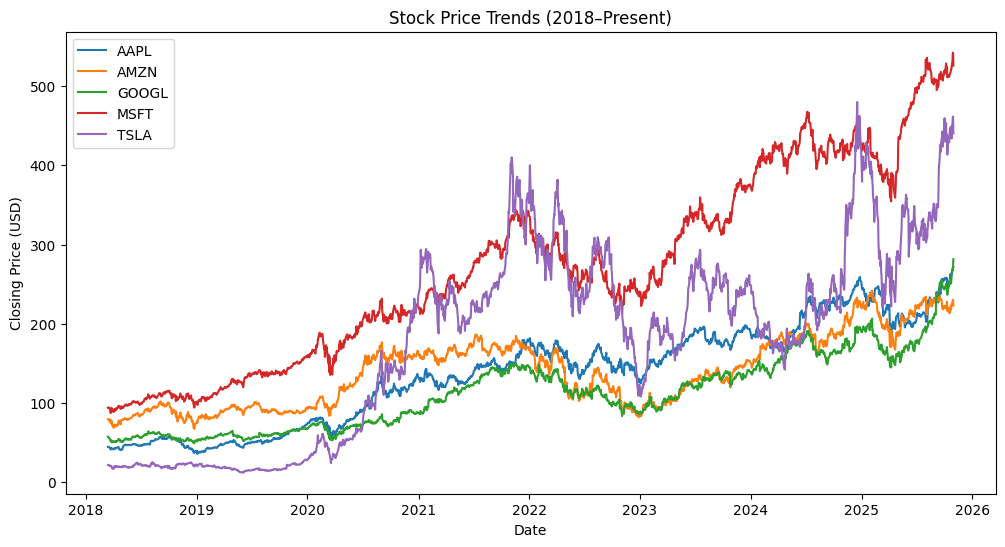

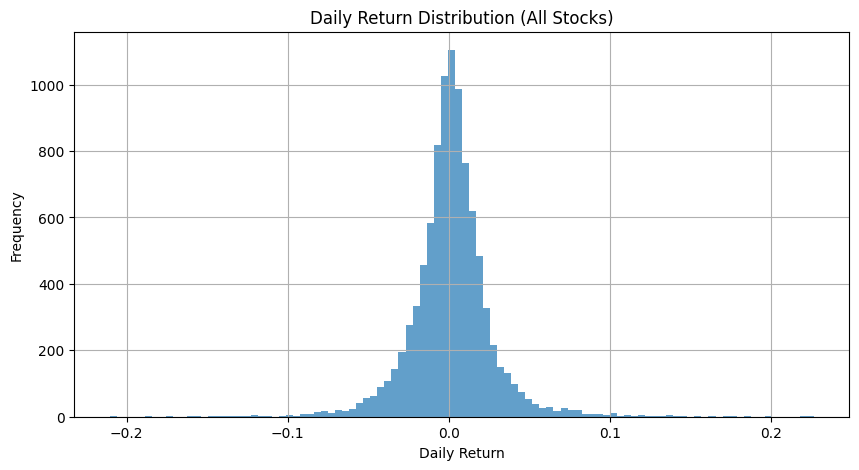

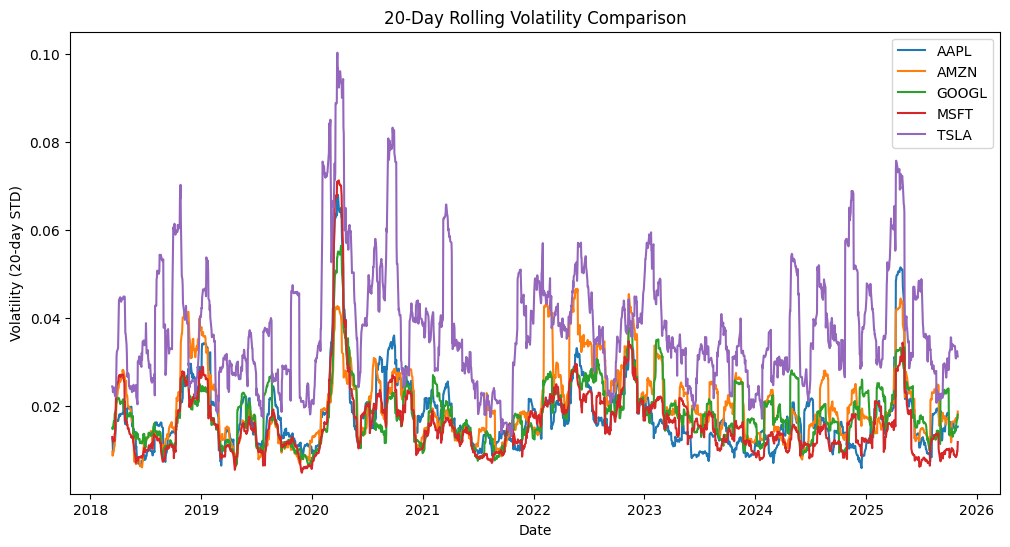

In [20]:

plt.figure(figsize=(12,6))
for s in df["symbol"].unique():
    sub = df[df["symbol"] == s]
    plt.plot(sub["date"], sub["close"], label=s)
plt.title("Stock Price Trends (2018–Present)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
df["daily_return"].hist(bins=100, alpha=0.7)
plt.title("Daily Return Distribution (All Stocks)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,6))
for s in df["symbol"].unique():
    sub = df[df["symbol"] == s]
    plt.plot(sub["date"], sub["volatility_20"], label=s)
plt.title("20-Day Rolling Volatility Comparison")
plt.xlabel("Date")
plt.ylabel("Volatility (20-day STD)")
plt.legend()
plt.show()


In [21]:
import numpy as np

df_ml = df.copy()

df_ml["target_next_return"] = df_ml.groupby("symbol")["daily_return"].shift(-1)

for lag in [1, 2, 3, 5, 10]:
    df_ml[f"lag_return_{lag}"] = df_ml.groupby("symbol")["daily_return"].shift(lag)


df_ml["rolling_return_5"] = df_ml.groupby("symbol")["daily_return"].rolling(5).mean().reset_index(level=0, drop=True)
df_ml["rolling_volatility_10"] = df_ml.groupby("symbol")["daily_return"].rolling(10).std().reset_index(level=0, drop=True)

df_ml = df_ml.dropna().reset_index(drop=True)

features = [
    "ma_20", "ma_50", "volatility_20", "lag_return_1", "lag_return_2", "lag_return_3",
    "lag_return_5", "lag_return_10", "rolling_return_5", "rolling_volatility_10"
]
target = "target_next_return"

print("Final features used for ML:", features)
print("Target variable:", target)
print("ML dataset shape:", df_ml.shape)

print("\nRows per symbol (post-ML prep):")
print(df_ml.groupby("symbol").size().to_dict())

display(df_ml.head(10))


Final features used for ML: ['ma_20', 'ma_50', 'volatility_20', 'lag_return_1', 'lag_return_2', 'lag_return_3', 'lag_return_5', 'lag_return_10', 'rolling_return_5', 'rolling_volatility_10']
Target variable: target_next_return
ML dataset shape: (9545, 21)

Rows per symbol (post-ML prep):
{'AAPL': 1909, 'AMZN': 1909, 'GOOGL': 1909, 'MSFT': 1909, 'TSLA': 1909}


,date,symbol,open,high,low,close,adj_close,volume,daily_return,ma_20,...,volatility_20,cumulative_return,target_next_return,lag_return_1,lag_return_2,lag_return_3,lag_return_5,lag_return_10,rolling_return_5,rolling_volatility_10
0,2018-03-28 04:00:00,AAPL,41.812500,42.505001,41.297501,41.619999,39.185181,166674000,-0.011049,41.151020,...,0.016930,0.970387,0.007808,-0.025641,0.047472,-0.023157,-0.022654,-0.008501,-0.005301,0.021289
1,2018-03-29 04:00:00,AAPL,41.952499,42.937500,41.724998,41.945000,39.491146,153594000,0.007808,41.066049,...,0.016752,0.977964,-0.006556,-0.011049,-0.025641,0.047472,-0.014130,0.001177,-0.000913,0.021662
2,2018-04-02 04:00:00,AAPL,41.660000,42.235001,41.117500,41.669998,39.232239,150347200,-0.006556,40.953892,...,0.016647,0.971552,0.010259,0.007808,-0.011049,-0.025641,-0.023157,-0.003527,0.002407,0.021644
3,2018-04-03 04:00:00,AAPL,41.910000,42.187500,41.220001,42.097500,39.634735,121112000,0.010259,40.854682,...,0.016846,0.981520,0.019122,-0.006556,0.007808,-0.011049,0.047472,-0.015279,-0.005036,0.021978
4,2018-04-04 04:00:00,AAPL,41.220001,43.002499,41.192501,42.902500,40.392639,138422000,0.019122,40.795131,...,0.017516,1.000288,0.006934,0.010259,-0.006556,0.007808,-0.025641,-0.000342,0.003917,0.023149
5,2018-04-05 04:00:00,AAPL,43.145000,43.557499,43.020000,43.200001,40.672737,107732800,0.006934,40.768888,...,0.017502,1.007225,-0.025579,0.019122,0.010259,-0.006556,-0.011049,-0.022654,0.007514,0.022060
6,2018-04-06 04:00:00,AAPL,42.742500,43.119999,42.049999,42.095001,39.632381,140021200,-0.025579,40.668147,...,0.018141,0.981461,0.009918,0.006934,0.019122,0.010259,0.007808,-0.014130,0.000836,0.023206
7,2018-04-09 04:00:00,AAPL,42.470001,43.272499,42.462502,42.512501,40.025455,116070800,0.009918,40.551284,...,0.017799,0.991195,0.018818,-0.025579,0.006934,0.019122,-0.006556,-0.023157,0.004131,0.021863
8,2018-04-10 04:00:00,AAPL,43.250000,43.500000,42.882500,43.312500,40.778645,113634400,0.018818,40.451602,...,0.018246,1.009847,-0.004675,0.009918,-0.025579,0.006934,0.010259,0.047472,0.005843,0.016692
9,2018-04-11 04:00:00,AAPL,43.057499,43.480000,42.924999,43.110001,40.588001,89726400,-0.004675,40.362984,...,0.018173,1.005126,0.009859,0.018818,0.009918,-0.025579,0.019122,-0.025641,0.001083,0.014186



Symbol: AAPL
Accuracy: 0.4479
Confusion Matrix:
 [[155   5]
 [207  17]]

Symbol: AMZN
Accuracy: 0.4896
Confusion Matrix:
 [[166  17]
 [179  22]]

Symbol: GOOGL
Accuracy: 0.5443
Confusion Matrix:
 [[ 42 126]
 [ 49 167]]

Symbol: MSFT
Accuracy: 0.5182
Confusion Matrix:
 [[145  24]
 [161  54]]

Symbol: TSLA
Accuracy: 0.5130
Confusion Matrix:
 [[ 96  89]
 [ 98 101]]

Model Accuracy per Symbol:
symbol
AAPL     0.447917
AMZN     0.489583
GOOGL    0.544271
MSFT     0.518229
TSLA     0.513021
dtype: float64


/tmp/ipython-input-1139888524.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_summary = df_pred.dropna(subset=["predicted_movement"]).groupby("symbol").apply(


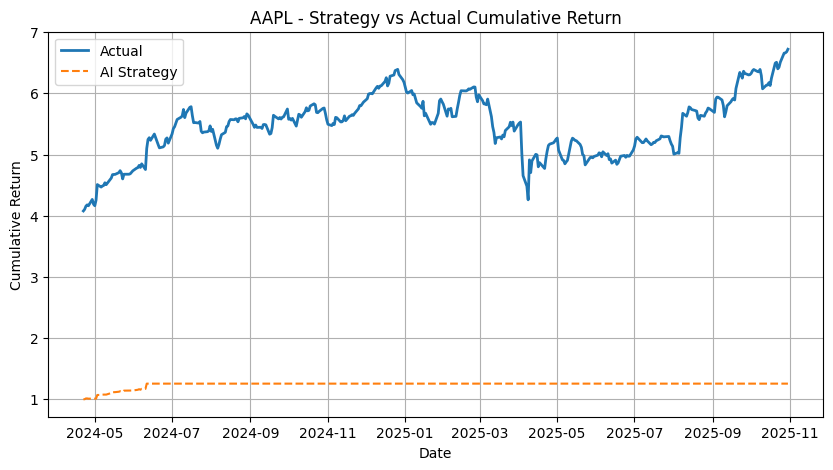

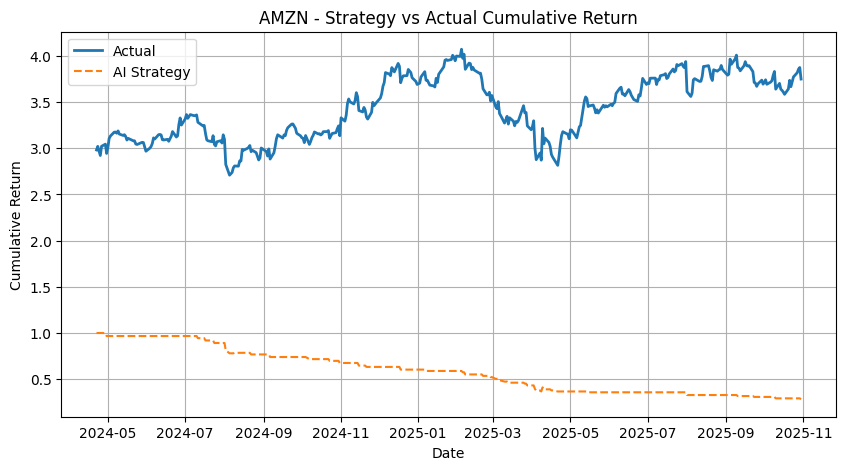

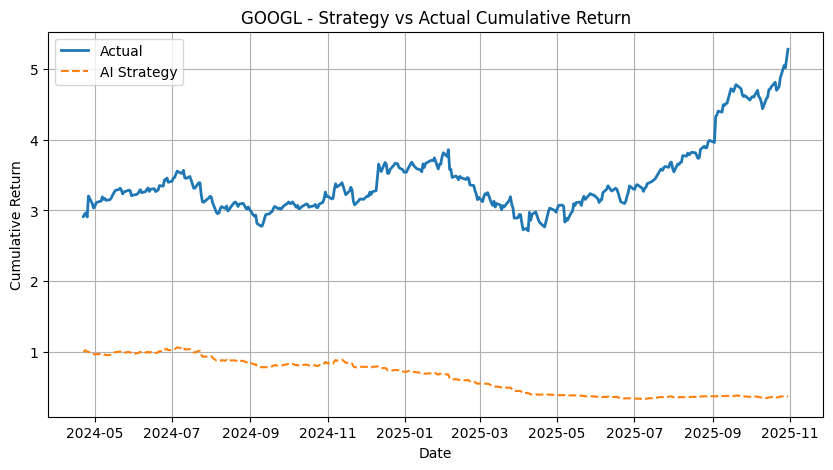

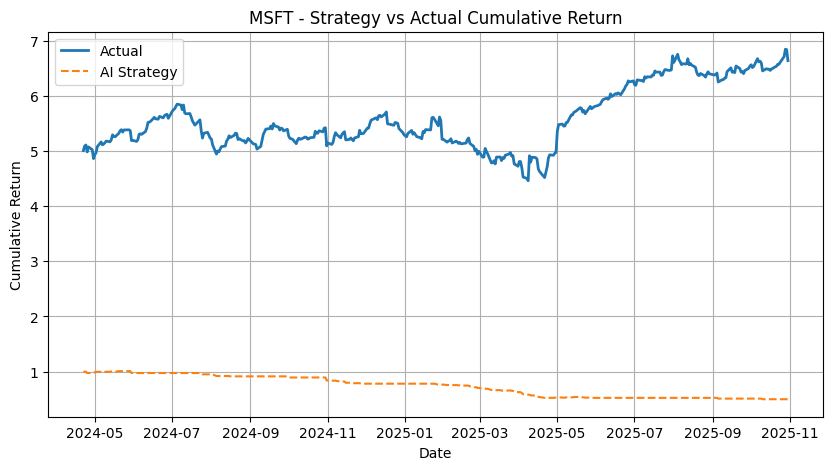

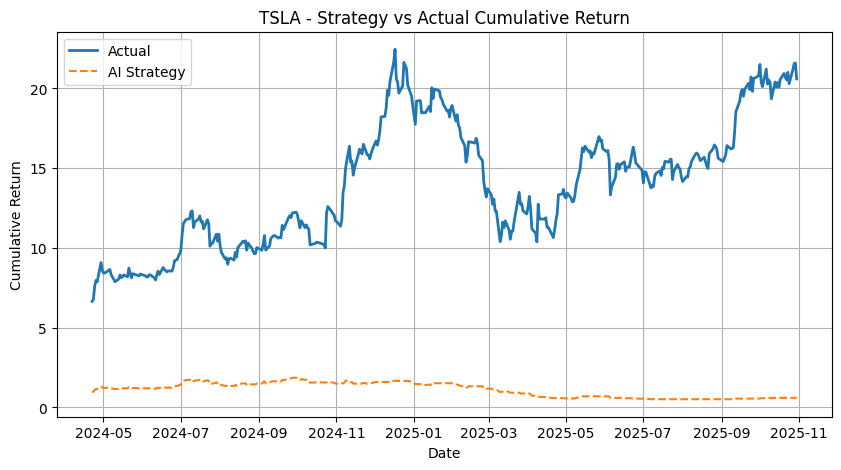

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X_cols = ["daily_return", "ma_20", "ma_50", "volatility_20"]
y_col = "target"
df_ml = prices_clean.copy()
df_ml["target"] = (df_ml["daily_return"].shift(-1) > 0).astype(int)

results = []

for symbol, group in df_ml.groupby("symbol"):
    group = group.sort_values("date").reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train, test = group.iloc[:split_idx], group.iloc[split_idx:]


    X_train = train[X_cols].dropna()
    y_train = train.loc[X_train.index, y_col]

    X_test = test[X_cols].copy()
    y_test = test[y_col].copy()
    X_test_valid = X_test.dropna()
    y_test_valid = y_test.loc[X_test_valid.index]

    model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)


    preds = model.predict(X_test_valid)


    acc = accuracy_score(y_test_valid, preds)
    cm = confusion_matrix(y_test_valid, preds)

    print(f"\nSymbol: {symbol}")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)

    test = test.copy()
    test["predicted_movement"] = np.nan
    test.loc[X_test_valid.index, "predicted_movement"] = preds


    test["strategy_return"] = test["predicted_movement"].fillna(0) * test["daily_return"]
    test["strategy_cumulative"] = (1 + test["strategy_return"]).cumprod()

    results.append(test)

df_pred = pd.concat(results).reset_index(drop=True)

acc_summary = df_pred.dropna(subset=["predicted_movement"]).groupby("symbol").apply(
    lambda g: accuracy_score(g["target"], g["predicted_movement"])
)
print("\nModel Accuracy per Symbol:")
print(acc_summary)

for symbol, group in df_pred.groupby("symbol"):
    plt.figure(figsize=(10,5))
    plt.plot(group["date"], group["cumulative_return"], label="Actual", linewidth=2)
    plt.plot(group["date"], group["strategy_cumulative"], label="AI Strategy", linestyle="--")
    plt.title(f"{symbol} - Strategy vs Actual Cumulative Return")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()


In [27]:
import os

out_csv = "data/processed/financial_ai_ready.csv"
out_parquet = "data/processed/financial_ai_ready.parquet"

os.makedirs(os.path.dirname(out_csv), exist_ok=True)

df_pred.to_csv(out_csv, index=False)
print(f"Saved CSV to {out_csv}")

df_pred.to_parquet(out_parquet, index=False, engine="pyarrow")
print(f"Saved Parquet to {out_parquet}")


Saved CSV to data/processed/financial_ai_ready.csv
Saved Parquet to data/processed/financial_ai_ready.parquet


In [28]:
from google.colab import files

files.download("data/processed/financial_ai_ready.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>